# Clustering roof dataset with benchmark

The t-SNE algorithm is used to cluster the roofs dataset.

In [1]:
# import the necessary packages
from sklearn.metrics import classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.utils.linear_assignment_ import linear_assignment
from bhtsne import tsne
import numpy as np
import sys
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros, float32
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from six.moves import cPickle as pickle
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#### Load data

In [3]:
# Load data from pickle file

pickle_file = 'data/roofs_dataset_processed.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    buildings = save['buildings']
    bg_dataset = save['bg_dataset']
    roof_dataset_orig = save['roof_dataset_orig']
    roof_dataset = save['roof_dataset']
    del save  # hint to help gc free up memory
    
pickle_file = 'data/labelled_samples.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    roofs_train_sample = save['train_sample']
    roofs_test_sample = save['test_sample']
    del save  # hint to help gc free up memory

#### Accuracy metric elements

In [4]:
def cluster_acc(y_true, y_pred):
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

In [5]:
def cluster_acc_with_merging(y_true, y_pred):
    mappings = list(itertools.combinations_with_replacement(range(y_true.max()+1), y_pred.max()+1))
    accs = []
    for mapping in mappings:
        y_pred_map = np.array([mapping[y] for y in y_pred])
        accs.append(cluster_acc(y_true, y_pred_map)[0])
    accs = np.array(accs)
    return accs.max(), mappings[np.argmax(accs)]

In [6]:
# Load labels and index of labelled data

acc_sample = np.array(roofs_train_sample['ind'])
labels = np.array(roofs_train_sample['lab'])

#### Display functions

In [8]:
def show_dataset(dataset, grid_size=(5,5), to_rgb=False, title=None):
    fig, axarr = plt.subplots(grid_size[0], grid_size[1], figsize=(20,2*grid_size[0]))
    fig.tight_layout() 
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            k = i*grid_size[1]+j
            try:
                img = dataset[k]
                if to_rgb:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
                img = np.ones(dataset[0].shape)* 255
            axarr[i, j].imshow(img, cmap='gray')
            axarr[i, j].axis("off")
            if title is not None:
                try:
                    axarr[i, j].set_title(title[k])
                except:
                    pass
    plt.show()  

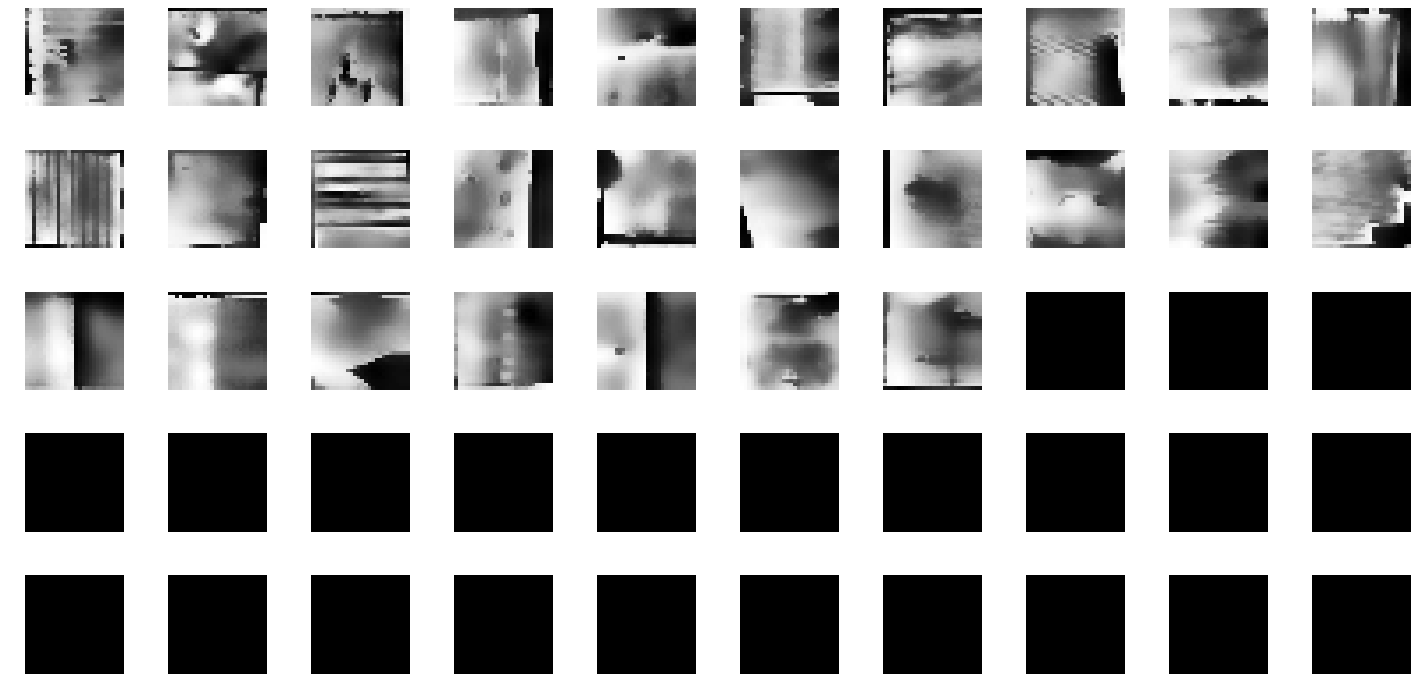

0


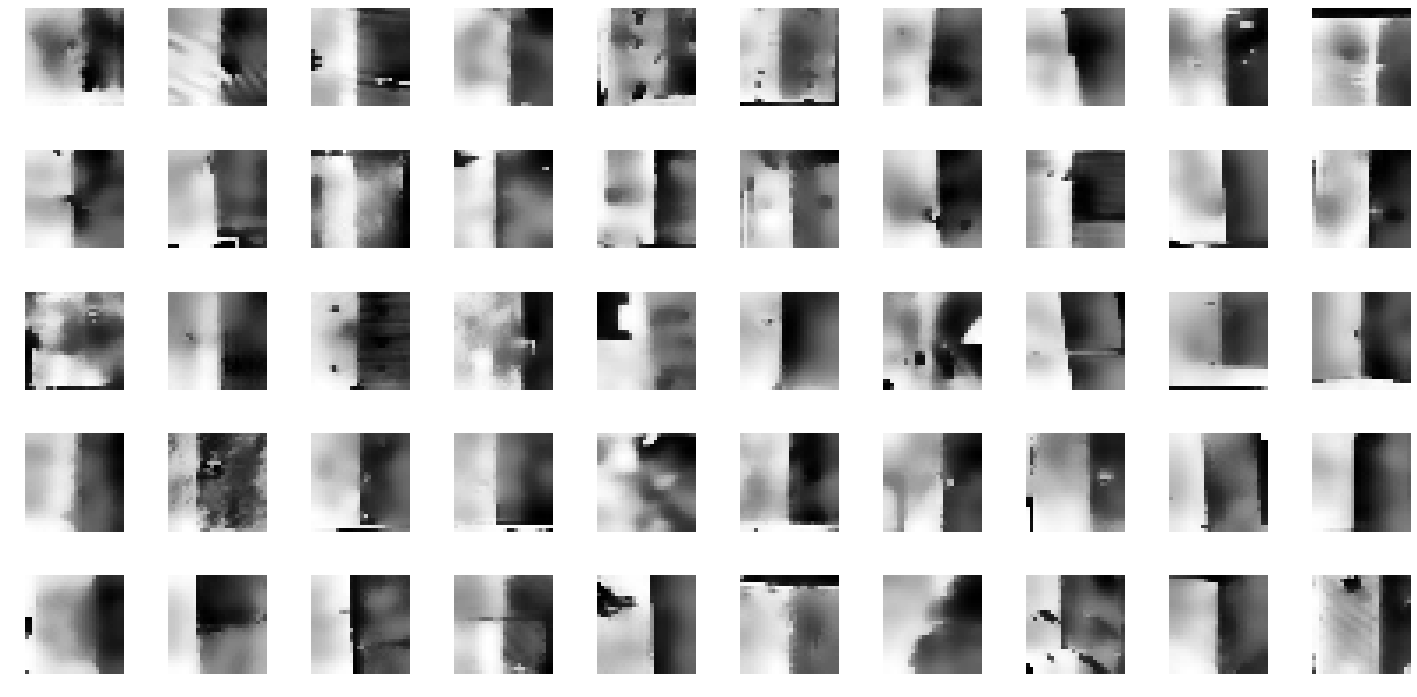

1


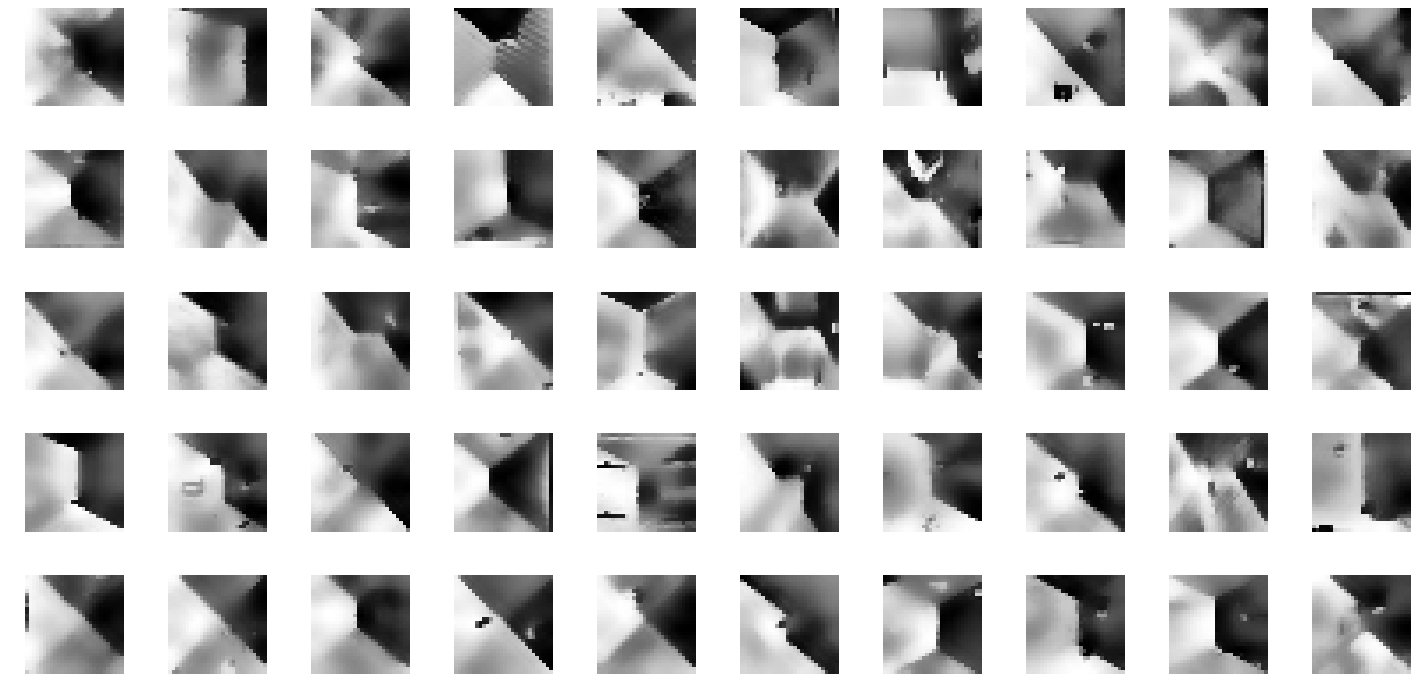

2


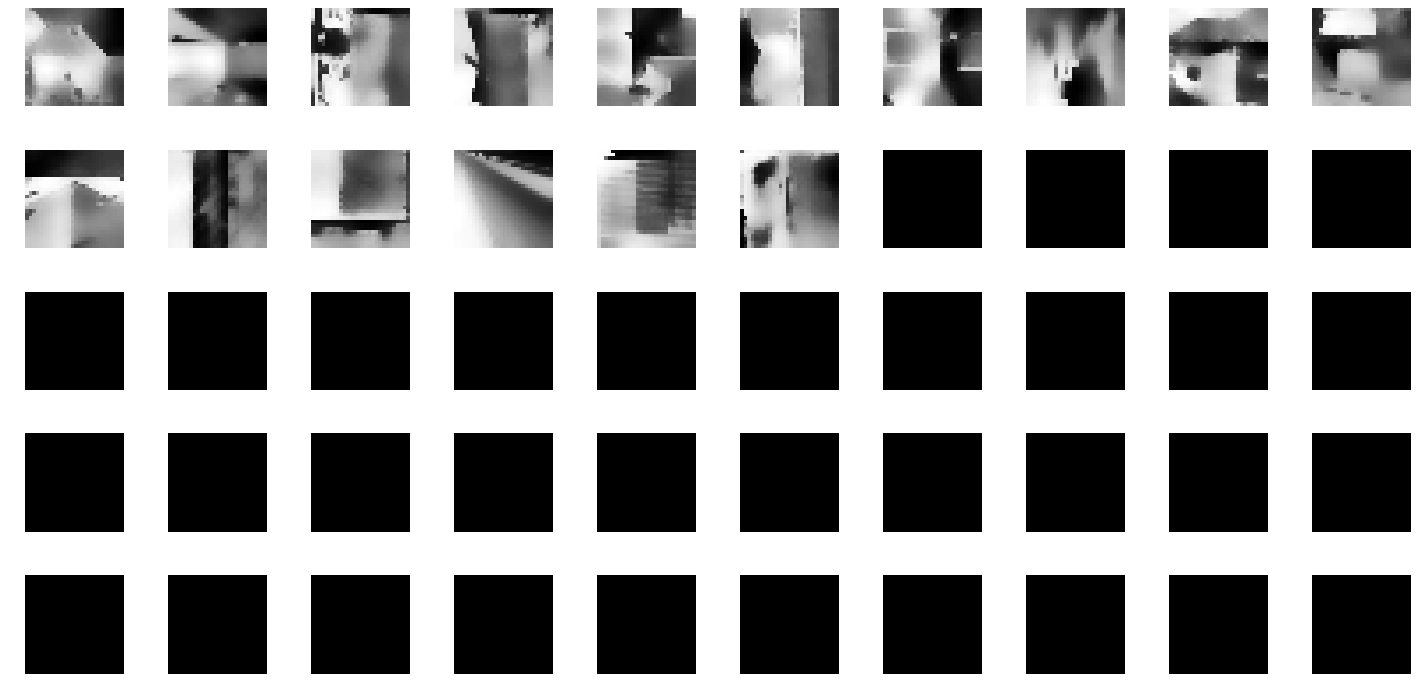

3


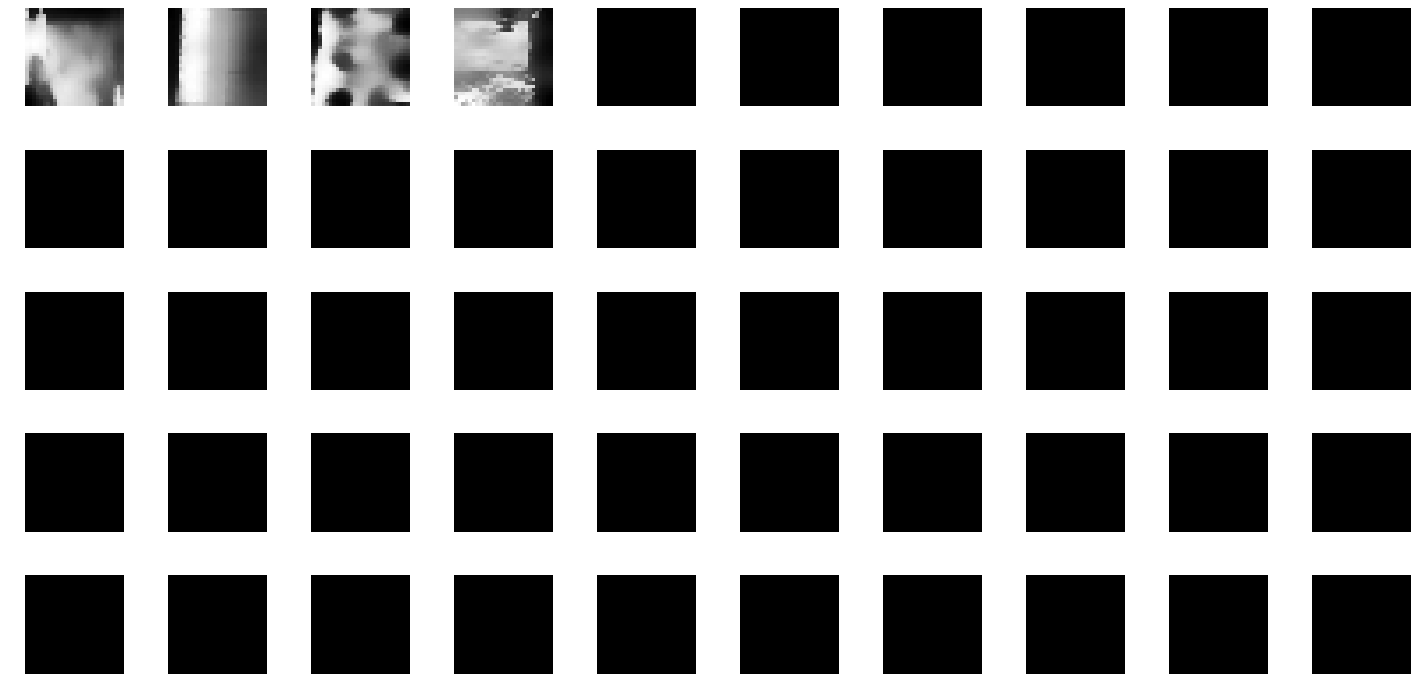

4


In [9]:
# Show the 200 labelled datapoints
roof_sample = roof_dataset[acc_sample]
for k in list(set(labels)):
    show_dataset(roof_sample[labels==k], grid_size=(5,10))
    print(k)

#### Benchmark clustering

In [10]:
# The flatten data
dataset_rd = roof_dataset.reshape(roof_dataset.shape[0],roof_dataset.shape[1]*roof_dataset.shape[2])

In [11]:
pca = PCA(n_components=25)
dataset_pca = pca.fit_transform(dataset_rd)

In [12]:
#tsne3 = TSNE(n_components=3, random_state=0)
#dataset_tsne3 = tsne3.fit_transform(dataset_pca)
dataset_tsne3 = tsne(dataset_pca,dimensions=3)

In [13]:
k_to_test = range(3,13)
scores = pd.DataFrame(index=k_to_test, columns=['silhouette', 'accuracy', 'nb_merged_clusters'])
for k in k_to_test:
    print("starting for "+str(k)+' clusters')
    bmk_clus = KMeans(n_clusters=k, random_state=0).fit_predict(dataset_tsne3)
    scores.loc[k,'silhouette']=silhouette_score(dataset_tsne3, bmk_clus, metric='euclidean')
    acc_res = cluster_acc_with_merging(labels, bmk_clus[acc_sample])
    scores.loc[k,'accuracy']=acc_res[0]
    scores.loc[k,'nb_merged_clusters']=len(set(acc_res[1]))

starting for 3 clusters
starting for 4 clusters
starting for 5 clusters
starting for 6 clusters
starting for 7 clusters
starting for 8 clusters
starting for 9 clusters
starting for 10 clusters
starting for 11 clusters
starting for 12 clusters


In [14]:
scores

,silhouette,accuracy,nb_merged_clusters
3,0.326487,0.71,2
4,0.334783,0.71,2
5,0.342613,0.56,3
6,0.333482,0.63,3
7,0.320748,0.6,4
8,0.306701,0.46,1
9,0.303589,0.575,3
10,0.315617,0.575,2
11,0.328004,0.53,4
12,0.335843,0.625,3


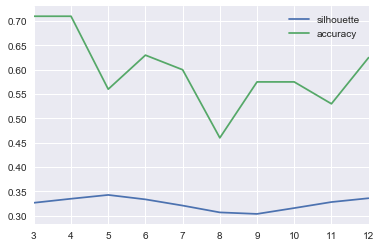

In [17]:
sns.set_style("darkgrid")
scores[['silhouette','accuracy']].plot()
plt.show()

In [16]:
best_k = scores['accuracy'].argmax()
bmk_clus = KMeans(n_clusters=best_k, random_state=0).fit_predict(dataset_tsne3)
y_pred = bmk_clus[acc_sample]
y_true = labels
merging = cluster_acc_with_merging(y_true, y_pred)[1]
print(merging)
bmk_clus_m = np.array([merging[k] for k in bmk_clus])
y_pred_m = bmk_clus_m[acc_sample]

(0, 1, 1)


In [19]:
# Save data to pickle file

pickle_file = 'data/roofs_bmk_results.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'bmk_clus_m': bmk_clus_m,
    'bmk_clus': bmk_clus,
    'y_pred_bmk': y_pred_m
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

<IPython.core.display.Javascript object>


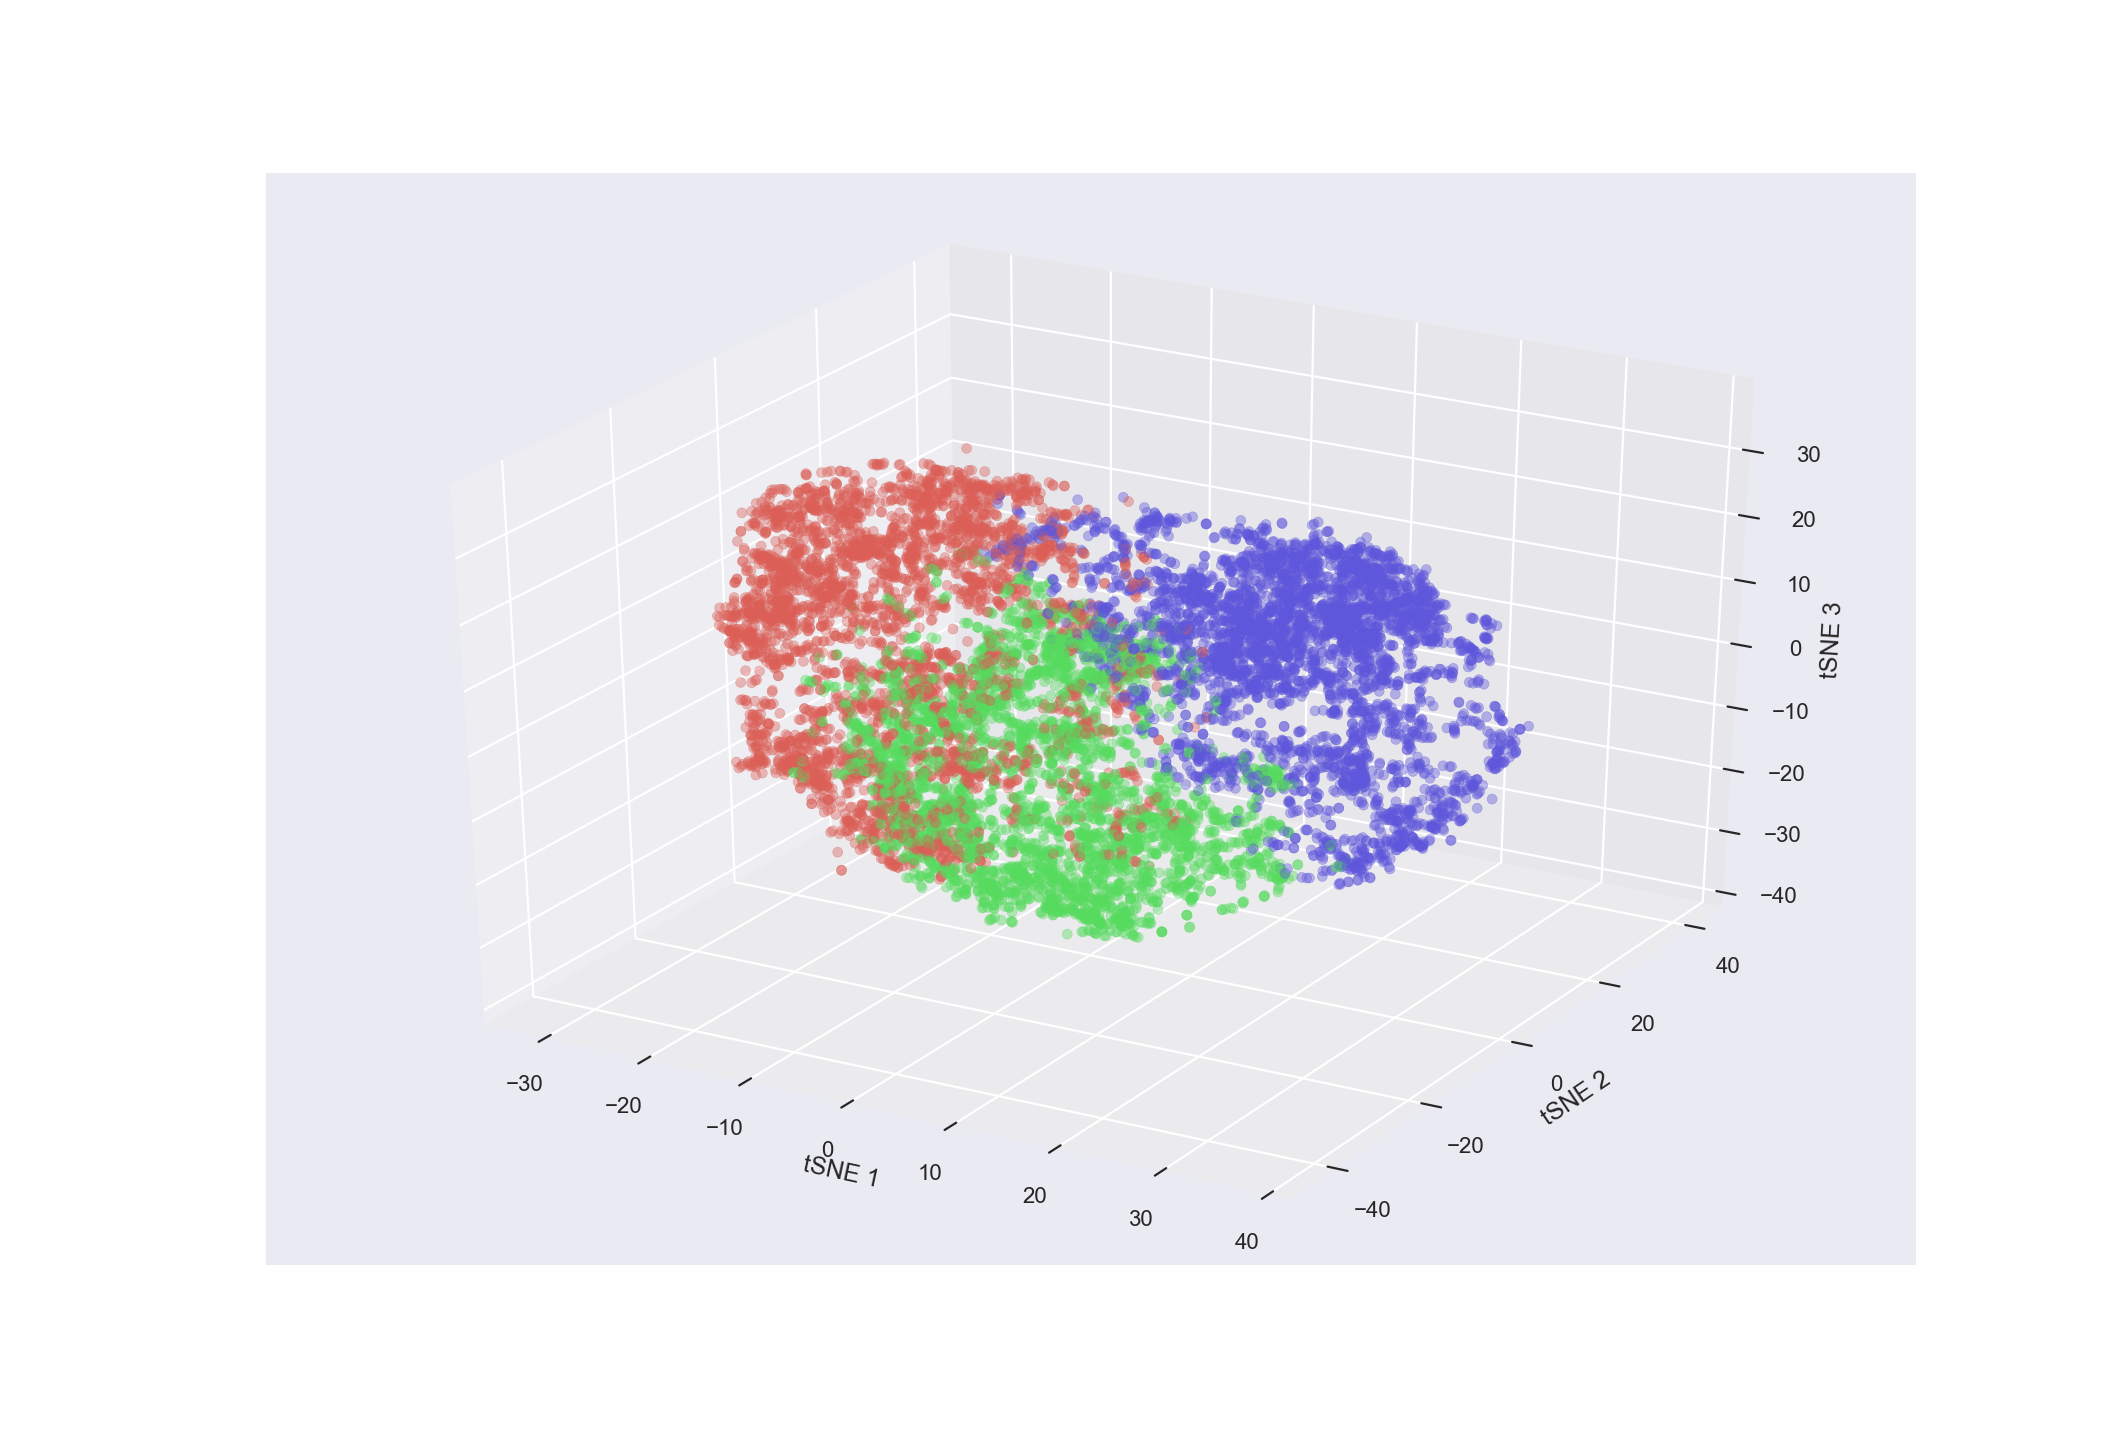

In [21]:
colors = sns.color_palette("hls", best_k)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('tSNE 1')
ax.set_ylabel('tSNE 2')
ax.set_zlabel('tSNE 3')
ax.scatter(dataset_tsne3[:,0],
           dataset_tsne3[:,1],
           dataset_tsne3[:,2],
           zdir='z',
           alpha=0.4,
           s=20,
           c=[colors[k] for k in bmk_clus],
           depthshade=True)
plt.show()

<IPython.core.display.Javascript object>


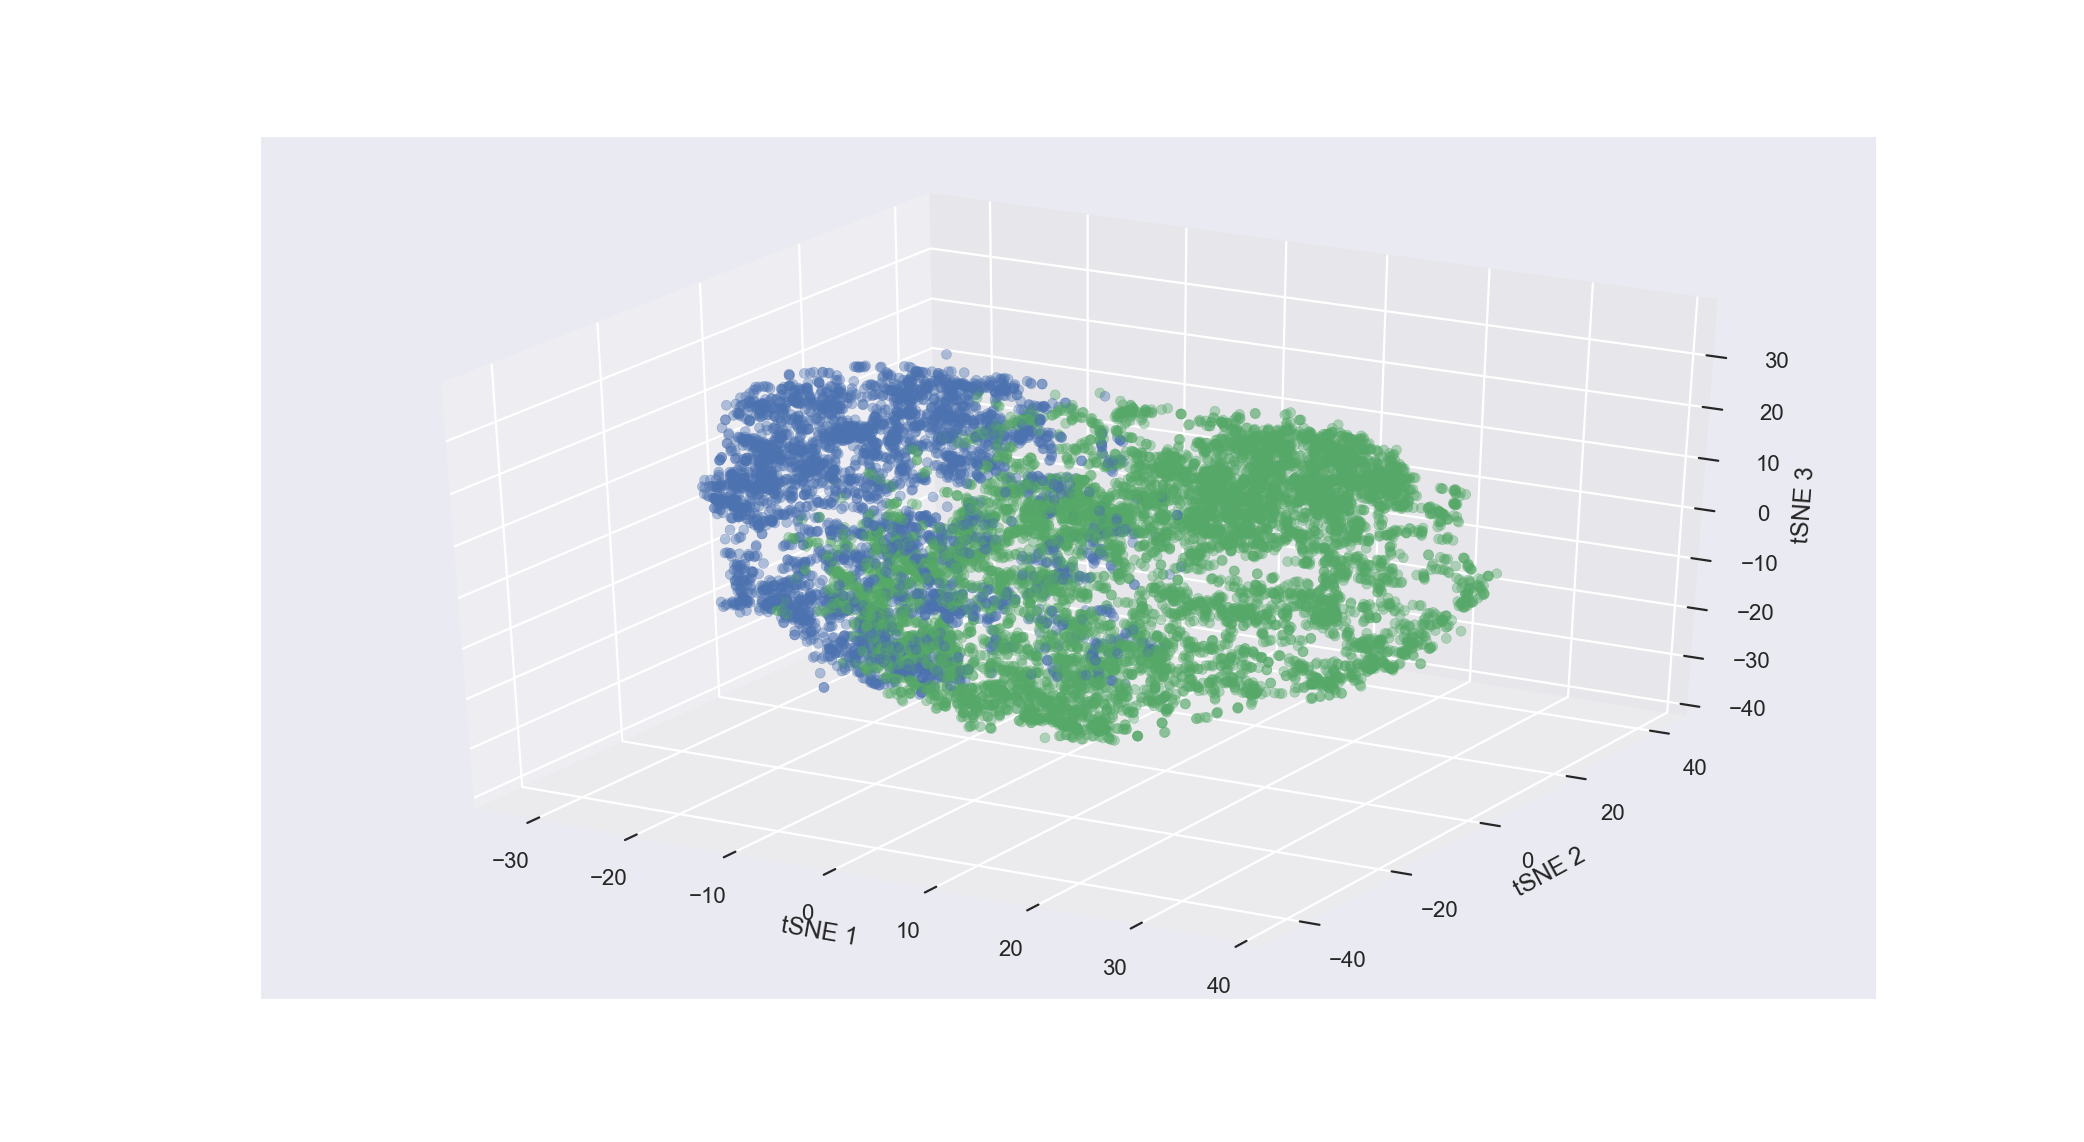

In [22]:
colors = sns.color_palette()
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('tSNE 1')
ax.set_ylabel('tSNE 2')
ax.set_zlabel('tSNE 3')
ax.scatter(dataset_tsne3[:,0],
           dataset_tsne3[:,1],
           dataset_tsne3[:,2],
           zdir='z',
           alpha=0.4,
           s=20,
           c=[colors[k] for k in bmk_clus_m],
           depthshade=True)
plt.show()

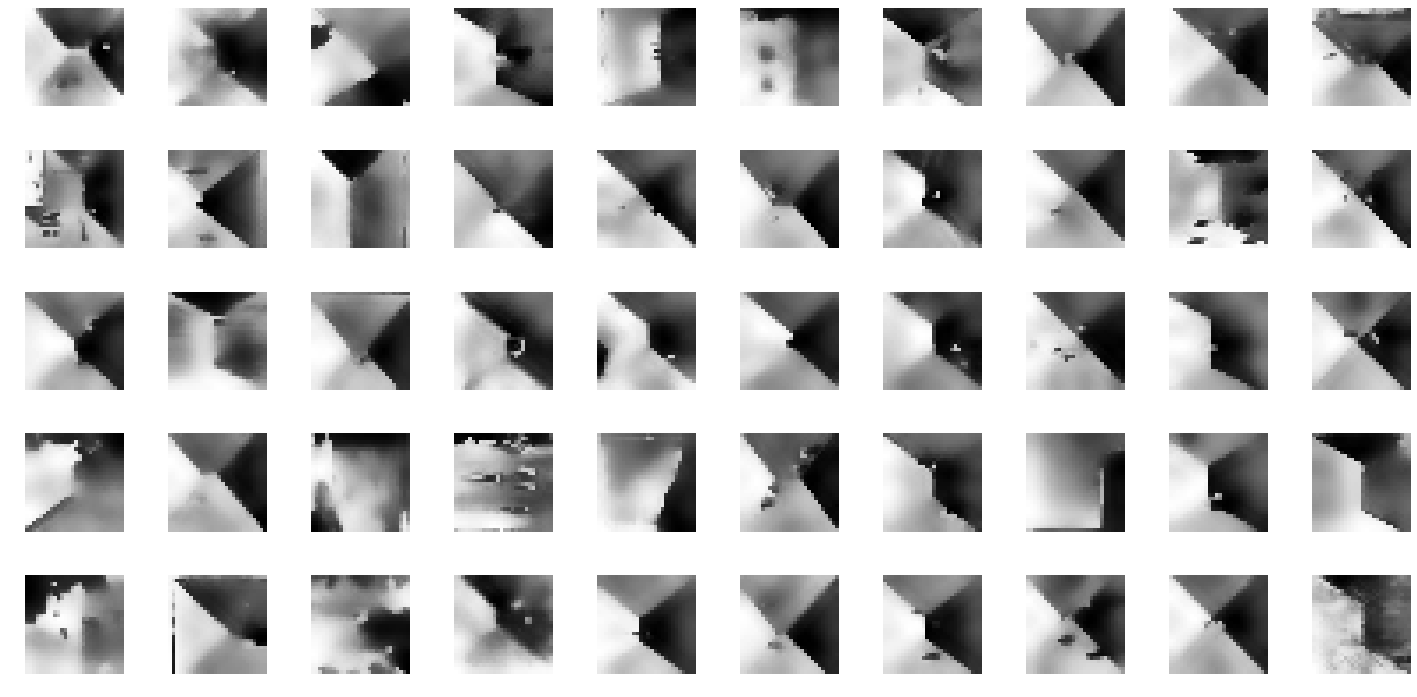

0


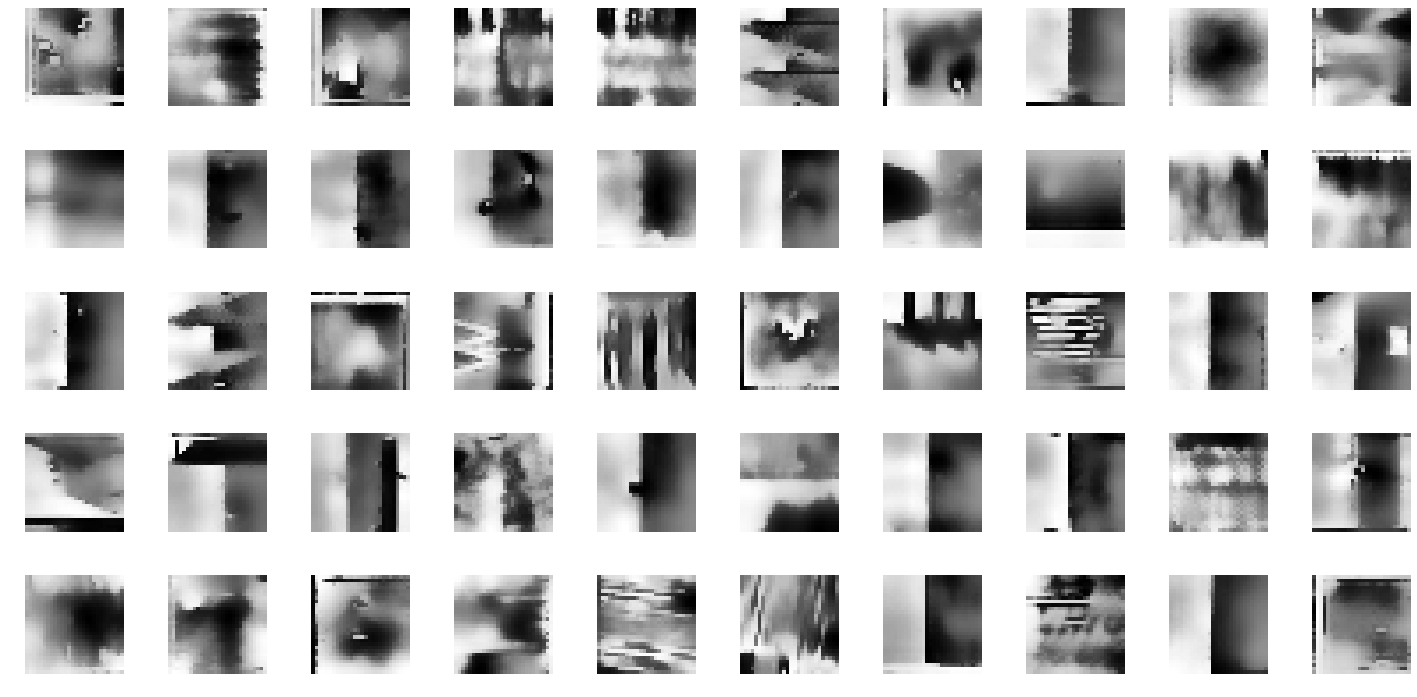

1


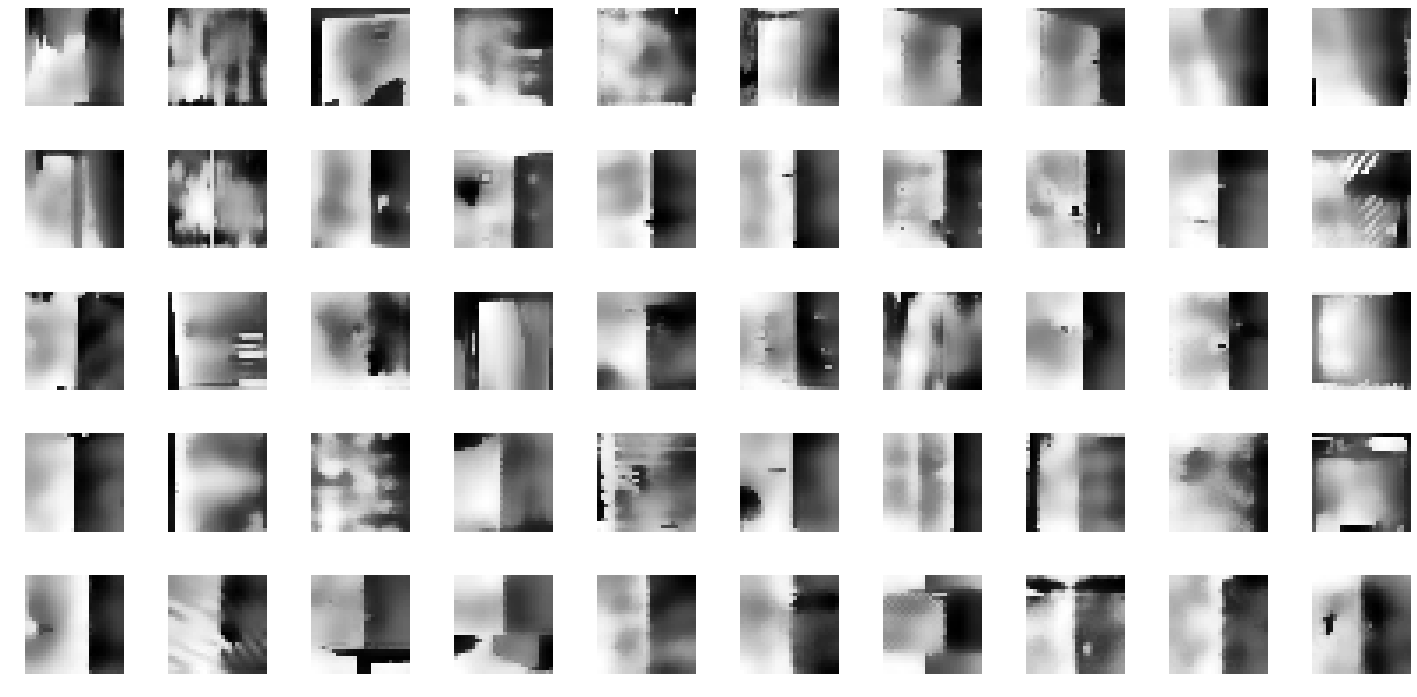

2


In [24]:
%matplotlib inline
for k in list(set(bmk_clus)):
    show_dataset(roof_dataset[bmk_clus==k], grid_size=(5,10))
    print(k)